# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


#  Exploring the Dataset

In [3]:
churn.shape

(46206, 21)

In [4]:
churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
count,46206.000000,46206.000000,46206.000000,46130.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,28416.000000,28416.000000,28416.000000
mean,42335.196879,45.874627,1.555707,41.411836,50.318617,51.364858,10.846708,8.237112,20.349825,15.249968,0.385015,75.188029,0.014640,0.191125,0.007038
std,22100.432751,33.077927,0.835529,15.263726,51.925537,20.855419,9.769887,8.341476,8.034631,10.982958,0.486604,73.519041,0.120108,0.393194,0.083600
min,1.000000,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000,0.000000,0.000000,0.000000
25%,24951.750000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000,0.000000,0.000000,0.000000
50%,43261.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000,0.000000,0.000000,0.000000
75%,61132.750000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000,0.000000,0.000000,0.000000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000,1.000000,1.000000,1.000000


In [5]:
churn.value_counts('CHURN_IND')

CHURN_IND
0    28416
1    17790
dtype: int64

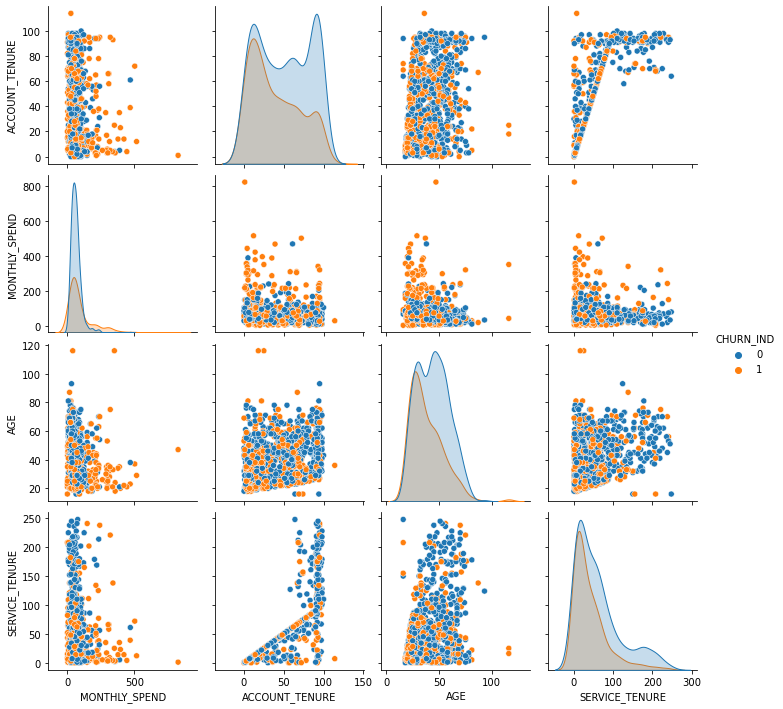

In [6]:
pairplot = sns.pairplot(data = churn.sample(1000),y_vars=['ACCOUNT_TENURE','MONTHLY_SPEND','AGE','SERVICE_TENURE'] 
                        ,x_vars = ['MONTHLY_SPEND','ACCOUNT_TENURE','AGE','SERVICE_TENURE'],hue ='CHURN_IND' )

There seems to be a relationship between low monthly spend and short service tenures leading to higher churn rates. Also as monthly spend increases people under the age of 50 are more likely to churn. Another possible observation is for accounts with low tenure and high monthly spend are seemingly more susceptible to churn.

A key observation from the pair plots is that as monthly spend increases churn rate also increases.

## Regression Data Preparation

Removal of irrelevant columns based on data/problem context

In [7]:
churn = churn.drop(['RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], axis = 1)

NaN value check with apporopriate deletion of rows

In [8]:
churn.isna().sum()
churn = churn.dropna(axis=0)

In [9]:
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW


Identification of potential 2 value categorical columns

In [10]:
churn.value_counts('COUNTRY_METRO_REGION')


COUNTRY_METRO_REGION
METRO      31765
COUNTRY    14364
dtype: int64

In [11]:
churn.value_counts('CFU')

CFU
CONSUMER          39078
SMALL BUSINESS     7051
dtype: int64

In [12]:
churn.value_counts('BYO_PLAN_STATUS')

BYO_PLAN_STATUS
NON BYO    35412
BYO        10717
dtype: int64

In [13]:
churn.value_counts('CONTRACT_STATUS')

CONTRACT_STATUS
ON-CONTRACT     28233
OFF-CONTRACT    12443
NO-CONTRACT      5453
dtype: int64

Conversion of identified 2 value categorical columns into numerical booleans

In [14]:
churn['Is Metro'] = (churn['COUNTRY_METRO_REGION'] =='METRO').astype(int)

In [15]:
churn['is BYO'] = (churn['BYO_PLAN_STATUS'] == 'BYO').astype(int)

In [16]:
churn['is CONSUMER'] = (churn['CFU'] == 'CONSUMER').astype(int)

Conversion of 3+ value categorical columns into numerical booleans

In [17]:
multi_df = pd.get_dummies(churn['CONTRACT_STATUS'])
churn = pd.concat([churn, multi_df], axis = 1)

In [18]:
multi_df = pd.get_dummies(churn['HANDSET_USED_BRAND'])
churn = pd.concat([churn, multi_df], axis = 1)
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,is CONSUMER,NO-CONTRACT,OFF-CONTRACT,ON-CONTRACT,APPLE,GOOGLE,HUAWEI,OTHER,SAMSUNG,UNKNOWN
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,1,0,1,0,0,0,0,0,1,0
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,1,0,1,0,1,0,0,0,0,0
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,1,0,1,0,1,0,0,0,0,0
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,1,0,1,0,1,0,0,0,0,0
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,1,0,1,0,1,0,0,0,0,0


In [19]:
multi_df = pd.get_dummies(churn['STATE'])
churn = pd.concat([churn, multi_df], axis = 1)

In [20]:
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,SAMSUNG,UNKNOWN,ACT,NSW,NT,QLD,SA,TAS,VIC,WA
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,1,0,0,0,0,0,0,0,0,1
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,0,0,0,1,0,0,0,0,0,0
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,0,0,0,0,0,0,0,0,0,1
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,0,0,0,0,0,0,0,0,1,0
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,0,0,0,1,0,0,0,0,0,0


Removal of non numerical columns

In [21]:
churn = churn.drop(['COUNTRY_METRO_REGION', 'BYO_PLAN_STATUS', 'CFU',
                    'CONTRACT_STATUS', 'HANDSET_USED_BRAND', 'STATE'], axis = 1)

# Logistic Regression

Data Split into a 20-80 split for test and train sets.

In [22]:
train, test = train_test_split(churn, test_size = 0.2)
print(train.shape)
print(test.shape)

(36903, 32)
(9226, 32)


Logistic Regression Model

In [23]:
X_train = train.drop(['CHURN_IND','CUST_ID'], axis = 1)
y_train = train['CHURN_IND']
X_test = test.drop(['CHURN_IND','CUST_ID'], axis = 1)
y_test = test['CHURN_IND']

In [24]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [25]:
lr.coef_

array([[-0.00687499, -0.00412856, -0.01752975, -0.00502145, -0.00647575,
         0.00662234, -0.08850868,  0.01320453, -0.01183246,  0.01149819,
        -0.3022246 , -0.78736103,  0.10146216,  0.47342379,  0.81073556,
        -0.42545707, -0.11658906, -0.02701041, -0.01503291,  0.25307644,
         0.01806641,  0.74619179, -0.12054499,  0.15627737,  0.00591576,
         0.27542317,  0.12457663,  0.03349099,  0.15150049,  0.23206284]])

# Evaluation

In [26]:
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)
print("Train Accuracy:")
print(accuracy_score(y_train, train_preds))
print("Test Accuracy:")
print(accuracy_score(y_test, test_preds))

Train Accuracy:
0.7267972793539821
Test Accuracy:
0.7181877303273357


Test Accuracy is quite close to that of the Train accuracy indicating that is no real issue of overfitting in the logistic regression model

Confusion Matrix

In [27]:
confusion = confusion_matrix(y_test, test_preds)
print("Confusion matrix on test set: ")
print(confusion)

Confusion matrix on test set: 
[[4734  961]
 [1639 1892]]


Text(0.5, 1.0, 'Confusion Matrix')

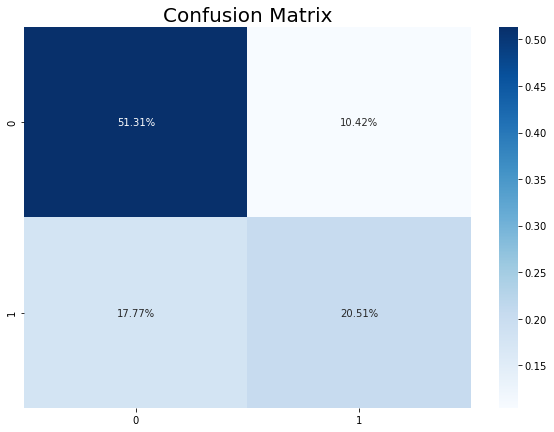

In [28]:
plt.figure(figsize = (10,7))
sns.heatmap(confusion/np.sum(confusion), annot=True,fmt='.2%',cmap='Blues')
plt.title("Confusion Matrix", size = 20)

As can be seen in the confusion matrix the the model is most effective in predicting those who will not churn. It is also relatively effective in predicting who will churn. Based on the requirments by telecom companies the model is quite effective as it predicts correctly ~70% of the time, predicts incorrectly that a customer will churn ~10% of the time and incorrectly predict a customer won't churn ~17% of the time. Thusly by using this model will only negatively affect the companies attempts at retaining customers on 17% of customers as the company would not attempt retention campaigns on those the model predicts will not churn.

# Feature Selection and Optimization

Feature ranking based on top 5 features

In [29]:
lr_model = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=lr_model, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=5)

In [30]:
y_test_hat = rfe.predict(X_test)
print("accuracy score on test set: ", accuracy_score(y_test, y_test_hat))

accuracy score on test set:  0.6570561456752656


In [31]:
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 17.000
Column: 1, Selected False, Rank: 26.000
Column: 2, Selected False, Rank: 16.000
Column: 3, Selected False, Rank: 24.000
Column: 4, Selected False, Rank: 22.000
Column: 5, Selected False, Rank: 23.000
Column: 6, Selected False, Rank: 11.000
Column: 7, Selected False, Rank: 12.000
Column: 8, Selected False, Rank: 14.000
Column: 9, Selected False, Rank: 20.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected False, Rank: 6.000
Column: 14, Selected False, Rank: 13.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected False, Rank: 15.000
Column: 17, Selected False, Rank: 2.000
Column: 18, Selected False, Rank: 18.000
Column: 19, Selected False, Rank: 3.000
Column: 20, Selected False, Rank: 21.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected False, Rank: 19.000
Column: 23, Selected False, Rank: 8.000
Column: 24, Selected False, Rank: 25.000

Based on the rankings the top 5 best features are : is Metro, is BYO, No_Contract, Off-Contract and Unknown Phone Brand.
This indicates that people not locked down to a contract or a phone are at high risk of churning.

## Accuracy with addtion of features

In [32]:
# Extremely laggy
acc_scores = []
for i in range(1,30):
    clf = LogisticRegression(max_iter=1000)
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    print("Acc on test set using", i, "features: ", acc_score)
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.6352698894428788
Acc on test set using 2 features:  0.6352698894428788
Acc on test set using 3 features:  0.6639930630825926
Acc on test set using 4 features:  0.6541296336440494
Acc on test set using 5 features:  0.6570561456752656
Acc on test set using 6 features:  0.6575980923477129
Acc on test set using 7 features:  0.6575980923477129
Acc on test set using 8 features:  0.6577064816822025
Acc on test set using 9 features:  0.6570561456752656
Acc on test set using 10 features:  0.658031649685671
Acc on test set using 11 features:  0.6579232603511814
Acc on test set using 12 features:  0.6575980923477129
Acc on test set using 13 features:  0.657814871016692
Acc on test set using 14 features:  0.657814871016692
Acc on test set using 15 features:  0.6577064816822025
Acc on test set using 16 features:  0.6606329937134185
Acc on test set using 17 features:  0.6606329937134185
Acc on test set using 18 features:  0.6637762844136137
Acc on test set using 

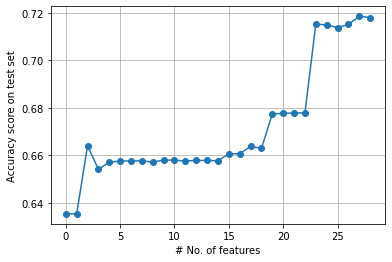

In [37]:
plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(acc_scores, marker = 'o')

In [38]:
#Cross Val Score
clf = LogisticRegression(max_iter=4000)
scores = cross_val_score(clf, churn.drop(['CHURN_IND','CUST_ID'], axis = 1),churn['CHURN_IND'], scoring='accuracy', cv=KFold(n_splits=10, shuffle=True))
cv_scores = scores.mean()
cv_std= scores.std()

In [39]:
print('Cross Validation Score:')
print(cv_scores)
print('Cross Validation StDev:')
print(cv_std)

Cross Validation Score:
0.723969699681638
Cross Validation StDev:
0.004982348627744597


The cross vaildation results further shows that the model is effective.

Based on these results the best results are achieved by utilising all features as opposed to limiting features. The model is more effective than randomly guessing that a user will not churn which has an effectivness of ~61% (28416 /46206) as opposed to the models ~72%. To further support the effectivness of the the confusion matrix shows that the worst case situation ie a false negative is only ~17%.